In [46]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import TimeDistributed
from keras.utils import generic_utils
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
import numpy as np
import scipy 
import math
import h5py
import time
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [47]:
import tensorflow as tf
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
#config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
#sess = tf.Session(config=config) 
#keras.backend.set_session(sess)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8169285498366464224
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6664037066033351285
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7801326797
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3579309041480533775
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:0a:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7782773556
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15296422900001529600
physical_device_desc: "device: 1, name: GeForce RTX 2080, pci bus id: 0000:42:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12145944999251171696
physical_device_desc: "device: XLA_GPU device"
, name: "/de

In [48]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print('Tensorflow: ', tf.__version__)

Tensorflow:  1.13.1


In [49]:
hello = tf.constant('Hello, TensorFlow!')

# when you run sess, you should see a bunch of lines with the word gpu in them (if install worked)
# otherwise, not running on gpu
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


In [55]:
syn_df = pd.read_csv('/home/whsu014/data/simple_syn_combined_0.1sd_6_eth.csv')
print(syn_df.shape)
print(syn_df.columns)
print(syn_df.iloc[0:5, :])

(140000, 20)
Index(['Unnamed: 0', 'id', 'quarter', 'ag_age', 'ag_sex', 'ag_eth', 'pt_nzdep',
       'imp_hxdiab', 'pt_tc_hdl_ratio', 'pt_bps', 'pt_bpd', 'pt_smoke',
       'imp_hxcvd', 'imp_hdl', 'imp_ldl', 'imp_tchol', 'PH_BL_LLD_ANY',
       'PH_BL_AHT_ANY', 'pt_familyhistory', 'tchdl'],
      dtype='object')
   Unnamed: 0     id  quarter    ag_age  ag_sex ag_eth  pt_nzdep  imp_hxdiab  \
0           0  10000        0  39.14871  Female    Oth         3           0   
1           1  10000        1  39.39871  Female    Oth         3           0   
2           2  10000        2  39.64871  Female    Oth         3           0   
3           3  10000        3  39.89871  Female    Oth         3           0   
4           4  10000        4  40.14871  Female    Oth         3           0   

   pt_tc_hdl_ratio    pt_bps    pt_bpd  pt_smoke  imp_hxcvd   imp_hdl  \
0         2.718664  113.6584  84.20549         0          0  1.623589   
1         2.718664  113.6584  84.20549         0          0 

In [56]:
# check categorical variables
print(syn_df.ag_sex.unique())
print(syn_df.ag_eth.unique())
syn_v = syn_df.values
print(syn_v.shape)

['Female' 'Male']
['Oth' 'Eur' 'Mao' 'Pac' 'Ind' 'Chi']
(140000, 20)


In [57]:
# one hot encode categorical variables 
for i in range(len(syn_v)):
    if syn_v[i, 4] == 'Male':
        syn_v[i, 4] = 0
    else:
        syn_v[i, 4] = 1
        
eth_v = np.zeros((len(syn_v), 6))
eth_idx = {'Chi': 0,
           'Eur': 1,
           'Ind': 2,
           'Mao': 3,
           'Oth': 4,
           'Pac': 5}

for i in range(len(syn_v)):
    eth_v[i, eth_idx[syn_v[i, 5]]] = 1

syn_v_1 = syn_v[:, 1:5]
syn_v_2 = syn_v[:, 6:]
syn_encoded_v = np.append(syn_v_1, eth_v, axis=1)
syn_encoded_v = np.append(syn_encoded_v, syn_v_2, axis=1)
print(syn_encoded_v.shape)
print(syn_encoded_v[0:5, :])

(140000, 24)
[[10000 0 39.148709999999994 1 0.0 0.0 0.0 0.0 1.0 0.0 3 0 2.718664
  113.6584 84.20549 0 0 1.623589 2.875279 4.378786 0 0 0
  2.720196946511845]
 [10000 1 39.398709999999994 1 0.0 0.0 0.0 0.0 1.0 0.0 3 0 2.718664
  113.6584 84.20549 0 0 1.623589 2.875279 4.378786 0 0 0
  2.6845696488452173]
 [10000 2 39.648709999999994 1 0.0 0.0 0.0 0.0 1.0 0.0 3 0 2.718664
  113.6584 84.20549 0 0 1.623589 2.875279 4.378786 0 0 0
  2.4842479478513715]
 [10000 3 39.898709999999994 1 0.0 0.0 0.0 0.0 1.0 0.0 3 0 2.718664
  113.6584 84.20549 0 0 1.623589 2.875279 4.378786 0 0 0
  2.653316792905103]
 [10000 4 40.148709999999994 1 0.0 0.0 0.0 0.0 1.0 0.0 3 0 2.718664
  113.6584 84.20549 0 0 1.623589 2.875279 4.378786 0 0 0
  2.7603294723172174]]


In [58]:
# normalise vectors to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(syn_encoded_v)

In [59]:
print(scaled.shape)

(140000, 24)


In [69]:
###############################################
# set up data for training with generator
# build x and y list
###############################################
x_list = []
y_list = []
x = np.empty([0, 24])
ground_truth = np.empty([0, 24])
##################
entry_start = 0
len_list = [0]
len_list_x = [0]
len_list_y = [0]
id_count = 0
##################
number_of_inds = 5000 #5000
for i in range(number_of_inds):
    start = i*28
    end = (i+1)*28
    ind_data = scaled[start:end, :]
    ##################################
    # create ground truth for forecast
    ##################################
    id_count += 1
    ind_x = ind_data[:-1, :-1]
    ind_y = ind_data[1:, -1:]
    ind_xy = np.append(ind_x, ind_y, axis=1)
    ground_truth = np.append(ground_truth, ind_xy, axis=0)
    ##################################
    # create data for 1 step forecast
    ##################################
    for i in range(len(ind_data)-1):
        x_list.append(ind_data[:(i+1), :])
        y_list.append(ind_data[(i+1), -1:])
        if i == len(ind_data)-2:
            x = np.append(x, x_list[-1], axis=0)
            n_rows = x_list[-1].shape[0]
            entry_start += n_rows
            len_list.append(entry_start)
    # store the indices to fold
    # changed from 10 fold to 2 fold 
    # due to amount of data and fair 
    # comparison with depmix
    if id_count % (number_of_inds//2) == 0 and \
        id_count != 0:
            len_list_x.append(len(x_list))
            len_list_y.append(len(y_list))

In [70]:
print(len(x_list))
print(len(y_list))
print(len(len_list_x))
print(len(len_list_y))
print(len_list_x)
print(len_list_y)
#print(len_list)

size = len(len_list)//2
print(size)
print("start", len_list[0])
print("end", len_list[size])
print('#########################')
f = 1
lstm_start = len_list_x[f]
lstm_end = len_list_x[f+1]

train1_x = x_list[:lstm_start]
train2_x = x_list[lstm_end:]
train_x = train1_x + train2_x

print(len(train1_x))
print(len(train2_x))
print(len(train_x))

135000
135000
3
3
[0, 67500, 135000]
[0, 67500, 135000]
2500
start 0
end 67500
#########################
67500
0
67500


Fold:  1
Epoch 1/50
 - 193s - loss: 0.0448 - val_loss: 0.0319

Epoch 00001: val_loss improved from inf to 0.03193, saving model to weights0.hdf5
Epoch 2/50
 - 184s - loss: 0.0201 - val_loss: 0.0247

Epoch 00002: val_loss improved from 0.03193 to 0.02469, saving model to weights0.hdf5
Epoch 3/50
 - 184s - loss: 0.0175 - val_loss: 0.0257

Epoch 00003: val_loss did not improve from 0.02469
Epoch 4/50
 - 184s - loss: 0.0159 - val_loss: 0.0190

Epoch 00004: val_loss improved from 0.02469 to 0.01903, saving model to weights0.hdf5
Epoch 5/50
 - 183s - loss: 0.0148 - val_loss: 0.0172

Epoch 00005: val_loss improved from 0.01903 to 0.01723, saving model to weights0.hdf5
Epoch 6/50
 - 183s - loss: 0.0140 - val_loss: 0.0147

Epoch 00006: val_loss improved from 0.01723 to 0.01471, saving model to weights0.hdf5
Epoch 7/50
 - 186s - loss: 0.0136 - val_loss: 0.0212

Epoch 00007: val_loss did not improve from 0.01471
Epoch 8/50
 - 185s - loss: 0.0132 - val_loss: 0.0143

Epoch 00008: val_loss improved 

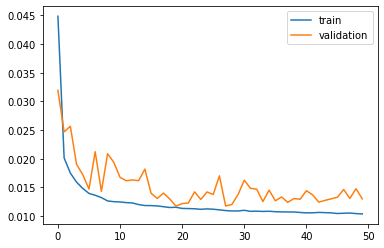

Training LSTM:  9261.42085146904
inv_y x and inv_yhat x are the same
Training and Testing LSTM:  9401.666112184525
End of fold 0: 9401.669679641724
Fold:  2
Epoch 1/50
 - 194s - loss: 0.0402 - val_loss: 0.0333

Epoch 00001: val_loss improved from inf to 0.03332, saving model to weights1.hdf5
Epoch 2/50
 - 184s - loss: 0.0207 - val_loss: 0.0307

Epoch 00002: val_loss improved from 0.03332 to 0.03072, saving model to weights1.hdf5
Epoch 3/50
 - 178s - loss: 0.0175 - val_loss: 0.0330

Epoch 00003: val_loss did not improve from 0.03072
Epoch 4/50
 - 175s - loss: 0.0164 - val_loss: 0.0376

Epoch 00004: val_loss did not improve from 0.03072
Epoch 5/50
 - 176s - loss: 0.0152 - val_loss: 0.0263

Epoch 00005: val_loss improved from 0.03072 to 0.02632, saving model to weights1.hdf5
Epoch 6/50
 - 176s - loss: 0.0145 - val_loss: 0.0209

Epoch 00006: val_loss improved from 0.02632 to 0.02085, saving model to weights1.hdf5
Epoch 7/50
 - 176s - loss: 0.0137 - val_loss: 0.0232

Epoch 00007: val_loss d

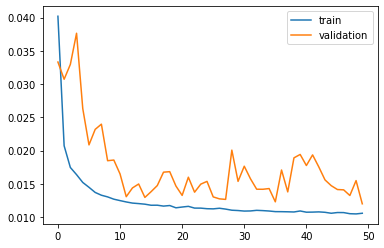

Training LSTM:  8817.568372249603
inv_y x and inv_yhat x are the same
Training and Testing LSTM:  8957.673077106476
End of fold 1: 8957.678676128387
rmse_lstm_list
Entire process took: 18359.43219780922


In [75]:
###########################################
# two fold cross validatioin
###########################################

# keras generators need to be 
# infinitely iterable
def train_generator(x_list, y_list):
    # 0.1 validatioin split
    train_length = (len(x_list)//10)*9
    while True:
        for i in range(train_length):
            train_x = np.array([x_list[i]])
            train_y = np.array([y_list[i]])
            yield train_x, train_y
            
def val_generator(x_list, y_list):
#    # 0.1 validation split
    val_length = len(x_list)//10
    while True:
        for i in range(-val_length, 0, 1):
            val_x = np.array([x_list[i]])
            val_y = np.array([y_list[i]])
            yield val_x, val_y
            
###########################################
# use keras.utils.Sequence for 
# thread-safe multiprocess
###########################################
'''
class DummySequence(Sequence):
    
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
    
    def __len__(self):
        #return len(self.x)
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x = self.x[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        #print("batch_x", batch_x.shape)
        #print("batch_y", batch_y.shape)
        return np.array(batch_x), batch_y 
'''

start_idx = 0
size = len(len_list)//2 #changed from 10

rmse_lstm_list = []
#rmse_var_list = []
rmse_naive_list = []

complete_inv_y = np.empty([0, 24])
complete_inv_yhat = np.empty([0, 24])
#complete_inv_var = np.empty([0, 38])
complete_inv_naive = np.empty([0, 24])

start_outside = time.time()

for f in range(2):  #2
    print("Fold: ", f+1)
    ##################################
    # forecast using LSTM
    ##################################
    lstm_start = len_list_x[f]
    lstm_end = len_list_x[f+1]
    

    train1_x = x_list[:lstm_start]
    train2_x = x_list[lstm_end:]
    train_x = train1_x + train2_x
    ##################################
    # train with only 100 inds 
    ##################################
    train_x = train_x[:33750]
    
    test_x = x_list[lstm_start:lstm_end]
    
    train1_y = y_list[:lstm_start]
    train2_y = y_list[lstm_end:]
    train_y = train1_y + train2_y
    ##################################
    # train with only 100 inds 
    ##################################
    train_y = train_y[:33750]
    
    test_y = y_list[lstm_start:lstm_end]
    
    # time training
    start_time = time.time()
    # design network
    #with tf.device('/device:GPU:0'):
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):

        train_seq = DummySequence(train_x[:len(train_x)//10*9], 
                                  train_y[:len(train_y)//10*9], 1)
        
        val_seq = DummySequence(train_x[-len(train_x)//10:],
                                train_y[-len(train_y)//10:], 1)
        
        model = Sequential()
        model.add(CuDNNLSTM(128, return_sequences=True,
                        input_shape=(None, 24)))
        model.add(CuDNNLSTM(128, return_sequences=True))
        model.add(CuDNNLSTM(128))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        weight = "weights" + str(f) + ".hdf5"
        checkpointer = ModelCheckpoint(filepath=weight,
                                    monitor='val_loss', verbose=1,
                                    save_best_only=True)
        history = model.fit_generator(generator=train_generator(train_x,
                                                                train_y),
                                        steps_per_epoch=(len(train_x)//10)*9,
                                        epochs=50,
                                        validation_data=val_generator(train_x,
                                                                    train_y),
                                        validation_steps=len(train_x)//10,
                                        callbacks=[checkpointer],
                                        verbose=2, shuffle=False)
        '''
        history = model.fit_generator(generator=train_seq,
                                    #steps_per_epoch=(len(train_x)//10)*9,
                                    epochs=50,
                                    validation_data=val_seq,
                                    #validation_steps=len(train_x)//10,
                                    callbacks=[checkpointer],
                                    verbose=2, shuffle=False,
                                    use_multiprocessing=False,
                                    workers=16)
        '''
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    end_time = time.time()
    print("Training LSTM: ", end_time - start_time)
    
    # LSTM prediction

    model.load_weights(weight)
    yhat = np.empty((0, 1))
    forecast = np.empty((0, 1))
    for i in range(len(test_x)):
        #yhat_pred = model.predict(np.array([test_x[i]]))
        #print("yhat_pred.shape: ", yhat_pred.shape)
        #yhat = np.append(yhat, yhat_pred, axis=0)
        if len(test_x[i]) < 8:
            yhat_pred = model.predict(np.array([test_x[i]]))
        elif len(test_x[i]) == 8:
            yhat_pred = model.predict(np.array([test_x[i]]))
            forecast = np.append(forecast, yhat_pred, axis=0)
        elif len(test_x[i]) > 8:
            adjusted_y = np.append(test_x[i][:-len(forecast), -1:], forecast, axis=0)
            test_x[i] = np.append(test_x[i][:, :-1], adjusted_y, axis=1)
            yhat_pred = model.predict(np.array([test_x[i]]))
            forecast = np.append(forecast, yhat_pred, axis=0)    
            if len(test_x[i]) == 27:
                forecast = np.empty((0, 1))
        yhat = np.append(yhat, yhat_pred, axis=0)
    start = len_list[start_idx]
    end = len_list[start_idx+size]
    xyhat = np.append(x[start:end, :-1], yhat, axis=1)
    inv_yhat = scaler.inverse_transform(xyhat)
    inv_y = scaler.inverse_transform(ground_truth[start:end, :])
    if np.array_equal(inv_y[:, :-1], inv_yhat[:, :-1]):
        print("inv_y x and inv_yhat x are the same")
    else:
        print("inv_y x and inv_yhat x are not the same")
    end_time = time.time()
    print("Training and Testing LSTM: ", end_time - start_time)
    #########################################################
    # forecasting using Vector Autoregression (VAR) and Naive
    #########################################################
    rmse_lstm = math.sqrt(mean_squared_error(inv_y[:, -1:], inv_yhat[:, -1:]))
    rmse_lstm_list.append(rmse_lstm)
    
    complete_inv_y = np.append(complete_inv_y, inv_y, axis=0)
    complete_inv_yhat = np.append(complete_inv_yhat, inv_yhat, axis=0)

    end_time = time.time()
    print("End of fold "+str(f)+":", end_time - start_time)
    start_idx += size
print("rmse_lstm_list")
print(rmse_lstm_list)
end_outside = time.time()
print("Entire process took:", end_outside - start_outside)

Fold:  1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 5s - loss: 0.0679 - val_loss: 0.1364

Epoch 00001: val_loss improved from inf to 0.13638, saving model to weights.hdf5
Epoch 2/5
 - 3s - loss: 0.0520 - val_loss: 0.1573

Epoch 00002: val_loss did not improve from 0.13638
Epoch 3/5
 - 3s - loss: 0.0449 - val_loss: 0.1588

Epoch 00003: val_loss did not improve from 0.13638
Epoch 4/5
 - 3s - loss: 0.0390 - val_loss: 0.1286

Epoch 00004: val_loss improved from 0.13638 to 0.12857, saving model to weights.hdf5
Epoch 5/5
 - 3s - loss: 0.0329 - val_loss: 0.1068

Epoch 00005: val_loss improved from 0.12857 to 0.10676, saving model to weights.hdf5


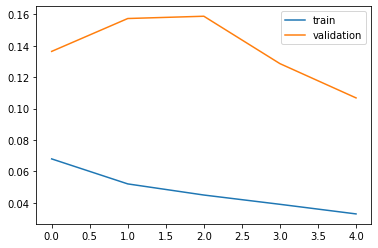

Training LSTM:  18.85527515411377
inv_y x and inv_yhat x are the same
Training and Testing LSTM:  19.77259063720703
End of fold 0: 19.77320694923401
Fold:  2
Epoch 1/5
 - 3s - loss: 0.0717 - val_loss: 0.0891

Epoch 00001: val_loss improved from inf to 0.08908, saving model to weights.hdf5
Epoch 2/5
 - 3s - loss: 0.0533 - val_loss: 0.1103

Epoch 00002: val_loss did not improve from 0.08908
Epoch 3/5
 - 3s - loss: 0.0419 - val_loss: 0.0667

Epoch 00003: val_loss improved from 0.08908 to 0.06672, saving model to weights.hdf5
Epoch 4/5
 - 3s - loss: 0.0316 - val_loss: 0.0785

Epoch 00004: val_loss did not improve from 0.06672
Epoch 5/5
 - 3s - loss: 0.0292 - val_loss: 0.0458

Epoch 00005: val_loss improved from 0.06672 to 0.04579, saving model to weights.hdf5


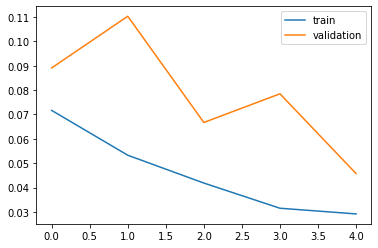

Training LSTM:  17.108866453170776
inv_y x and inv_yhat x are the same
Training and Testing LSTM:  18.0876407623291
End of fold 1: 18.08827805519104
rmse_lstm_list
Entire process took: 37.861908197402954
 

In [11]:
# profile code
###########################################
# two fold cross validatioin
###########################################

# keras generators need to be 
# infinitely iterable
def train_generator(x_list, y_list):
    # 0.1 validatioin split
    train_length = (len(x_list)//10)*9
    while True:
        for i in range(train_length):
            train_x = np.array([x_list[i]])
            train_y = np.array([y_list[i]])
            yield train_x, train_y
            
def val_generator(x_list, y_list):
    # 0.1 validation split
    val_length = len(x_list)//10
    while True:
        for i in range(-val_length, 0, 1):
            val_x = np.array([x_list[i]])
            val_y = np.array([y_list[i]])
            yield val_x, val_y
def profile_code():            
    start_idx = 0
    size = len(len_list)//2 #changed from 10

    rmse_lstm_list = []
    #rmse_var_list = []
    rmse_naive_list = []

    complete_inv_y = np.empty([0, 24])
    complete_inv_yhat = np.empty([0, 24])
    #complete_inv_var = np.empty([0, 38])
    complete_inv_naive = np.empty([0, 24])

    start_outside = time.time()

    for f in range(2):
        print("Fold: ", f+1)
        ##################################
        # forecast using LSTM
        ##################################
        lstm_start = len_list_x[f]
        lstm_end = len_list_x[f+1]

        train1_x = x_list[:lstm_start]
        train2_x = x_list[lstm_end:]
        train_x = train1_x + train2_x
        test_x = x_list[lstm_start:lstm_end]

        train1_y = y_list[:lstm_start]
        train2_y = y_list[lstm_end:]
        train_y = train1_y + train2_y
        test_y = y_list[lstm_start:lstm_end]

        # time training
        start_time = time.time()
        # design network
        #with tf.device('/device:GPU:0'):
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)): 
            model = Sequential()
            model.add(CuDNNLSTM(128, return_sequences=True,
                        input_shape=(None, 24)))
            model.add(CuDNNLSTM(128, return_sequences=True))
            model.add(CuDNNLSTM(128))
            model.add(Dense(1))
            model.compile(loss='mae', optimizer='adam')
            checkpointer = ModelCheckpoint(filepath="weights.hdf5",
                                        monitor='val_loss', verbose=1,
                                        save_best_only=True)
            history = model.fit_generator(generator=train_generator(train_x,
                                                                train_y),
                                        steps_per_epoch=(len(train_x)//10)*9,
                                        epochs=5,
                                        validation_data=val_generator(train_x,
                                                                    train_y),
                                        validation_steps=len(train_x)//10,
                                        callbacks=[checkpointer],
                                        verbose=2, shuffle=False)
        # plot history
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='validation')
        pyplot.legend()
        pyplot.show()

        end_time = time.time()
        print("Training LSTM: ", end_time - start_time)

        # LSTM prediction
        weight = "weights" + str(f) + ".hdf5"
        model.load_weights(weight)
        yhat = np.empty((0, 1))
        for i in range(len(test_x)):
            # one step forecast
            # yhat_pred = model.predict(np.array([test_x[i]]))
            # yhat = np.append(yhat, yhat_pred, axis=0)
            if len(test_x[i]) < 8:
                yhat_pred = model.predict(np.array([test_x[i]]))
            elif len(test_x[i]) == 8:
                yhat_pred = model.predict(np.array([test_x[i]]))
                forecast = np.append(forecast, yhat_pred, axis=0)
            elif len(test_x[i]) > 8:
                adjusted_y = np.append(test_x[i][:-len(forecast), -1:], 
                                   forecast, axis=0)
                test_x[i] = np.append(test_x[i][:, :-1], adjusted_y, axis=1)
                yhat_pred = model.predict(np.array([test_x[i]]))
                forecast = np.append(forecast, yhat_pred, axis=0)    
                if len(test_x[i]) == 27:
                    forecast = np.empty((0, 1))
            yhat = np.append(yhat, yhat_pred, axis=0)
        start = len_list[start_idx]
        end = len_list[start_idx+size]
        xyhat = np.append(x[start:end, :-1], yhat, axis=1)
        inv_yhat = scaler.inverse_transform(xyhat)
        inv_y = scaler.inverse_transform(ground_truth[start:end, :])
        if np.array_equal(inv_y[:, :-1], inv_yhat[:, :-1]):
            print("inv_y x and inv_yhat x are the same")
        else:
            print("inv_y x and inv_yhat x are not the same")
        end_time = time.time()
        print("Training and Testing LSTM: ", end_time - start_time)

        rmse_lstm = math.sqrt(mean_squared_error(inv_y[:, -1:], inv_yhat[:, -1:]))
        rmse_lstm_list.append(rmse_lstm)

        complet_inv_y = np.append(complete_inv_y, inv_y, axis=0)
        complete_inv_yhat = np.append(complete_inv_yhat, inv_yhat, axis=0)

        end_time = time.time()
        print("End of fold "+str(f)+":", end_time - start_time)
        start_idx += size
    print("rmse_lstm_list")
    end_outside = time.time()
    print("Entire process took:", end_outside - start_outside)
%prun profile_code()

In [76]:
#       'id', 'quarter', 'ag_age', 'ag_sex', 'ag_eth', 'pt_nzdep',
#       'imp_hxdiab', 'pt_tc_hdl_ratio', 'pt_bps', 'pt_bpd', 'pt_smoke',
#       'imp_hxcvd', 'imp_hdl', 'imp_ldl', 'imp_tchol', 'PH_BL_LLD_ANY',
#       'PH_BL_AHT_ANY', 'pt_familyhistory', 'tchdl'

#  'Chi': 0,
#  'Eur': 1,
#  'Ind': 2,
#  'Mao': 3,
#  'Oth': 4,
#  'Pac': 5

print(rmse_lstm_list)

complete_inv_y_df = pd.DataFrame(complete_inv_y) 
complete_inv_y_df.columns = ['id', 'quarter', 'ag_age', 'ag_sex',  
                             'Chi', 'Eur', 'Ind', 'Mao', 'Oth', 'Pac','pt_nzdep',
                             'imp_hxdiab', 'pt_tc_hdl_ratio', 'pt_bps', 'pt_bpd', 'pt_smoke',
                             'imp_hxcvd', 'imp_hdl', 'imp_ldl', 'imp_tchol', 'PH_BL_LLD_ANY',
                             'PH_BL_AHT_ANY', 'pt_familyhistory', 'tchdl']
print(complete_inv_y_df.shape)
complete_inv_y_df.to_csv('combined_0.1sd_train1250inds_y.csv', sep=",")

complete_inv_yhat_df = pd.DataFrame(complete_inv_yhat) 
complete_inv_yhat_df.columns = ['id', 'quarter', 'ag_age', 'ag_sex',  
                             'Chi', 'Eur', 'Ind', 'Mao', 'Oth', 'Pac','pt_nzdep',
                             'imp_hxdiab', 'pt_tc_hdl_ratio', 'pt_bps', 'pt_bpd', 'pt_smoke',
                             'imp_hxcvd', 'imp_hdl', 'imp_ldl', 'imp_tchol', 'PH_BL_LLD_ANY',
                             'PH_BL_AHT_ANY', 'pt_familyhistory', 'tchdl']
print(complete_inv_yhat_df.shape)
complete_inv_yhat_df.to_csv('combined_0.1sd_train1250inds_yhat_CuDNNLSTM.csv', sep=",")


[0.2800505783910089, 0.2472762607047981]
(135000, 24)
(135000, 24)


In [27]:
import tensorflow as tf
with keras.get_session()  as s:
    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
    run_metadata = tf.RunMetadata()

    # your fitting code and s run with run_options 

    to = timeline.Timeline(run_metadata.step_stats)
    trace = to.generate_chrome_trace_format()
    with open('full_trace.json', 'w') as out:
            out.write(trace)

AttributeError: module 'keras' has no attribute 'get_session'

In [11]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [19]:
# Test CuDNNLSTM
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import CuDNNLSTM
from keras.optimizers import RMSprop


class TestCudnnLSTM():

  def __init__(self):  
    self.max_length = 1000
    self.n_input_dim = 1    

    self.model = []
    
    self.config()
    self.create_model()
    
  def config(self):
    print("Keras version: " + keras.__version__)
    print("Tensorflow version: " + tf.__version__)
    
    config = tf.ConfigProto()
    return config
    
  def create_model(self):        
          
    print('Creating Model')
    model = Sequential()
    model.add(CuDNNLSTM(1,
                    return_sequences=True,
                    stateful=False,
                    kernel_initializer='he_normal',
                    input_shape=(self.max_length, self.n_input_dim)))
    print (model.summary())
    
    opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'],
                  weighted_metrics=['accuracy'],
                  sample_weight_mode='temporal')
  
    print('Model compiled')      
    self.model = model
    return self
      
    
if __name__ == "__main__":
  mt = TestCudnnLSTM()

Keras version: 2.2.4
Tensorflow version: 1.13.1
Creating Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_6 (CuDNNLSTM)     (None, 1000, 1)           16        
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None
Model compiled
